## Data Manipulation

In [2]:
import csv
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd


# read .dat to a list of lists
datContent = [i.strip().split() for i in open("data/krackad.dat").readlines()]

# Create 21 x 21 x 21 array
flat_data = np.array(datContent[26:])
data = np.reshape(flat_data, (21, 21, 21)).astype(int)

data.shape

(21, 21, 21)

## Aggregation Methods

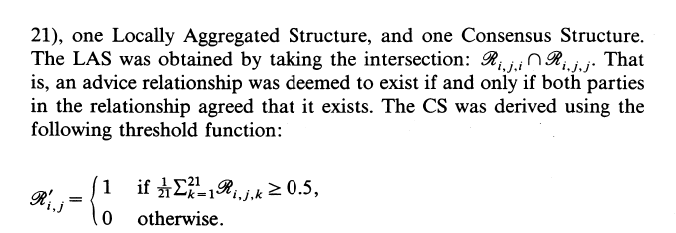

In [3]:
def consensus_structure(array):    
    return array.mean(axis=0).round()

def locally_aggregated_structures(array):
    las_array = np.zeros((21,21))

    for p1 in range(21):
        for p2 in range(21):
            if array[p1, p1, p2] == 1 and array[p2, p1, p2] == 1:
                las_array[p1, p2] = 1         
    return las_array


In [4]:
def plot_network(array):
    G = nx.DiGraph()
    G.add_nodes_from(range(1, 22))

    edges = np.argwhere(array>0) + 1
    G.add_edges_from(edges)
    return G

## Network Plots

In [5]:
plt.rcParams["figure.figsize"] = (12,8)

### Consensus Structure (CS)

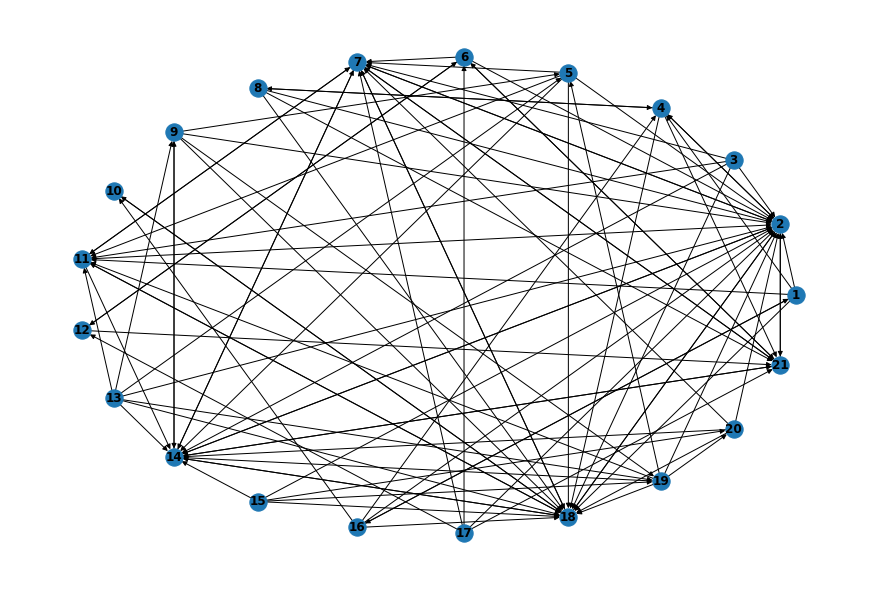

In [6]:
data_cons = consensus_structure(data)

G_cs = plot_network(data_cons)

nx.draw_shell(G_cs, with_labels=True, font_weight='bold')

In [7]:
df_cs = pd.DataFrame([], index=range(1, 22))
df_cs['CS Out Degree'] = pd.Series(dict(G_cs.out_degree()))
df_cs['CS In Degree'] = pd.Series(dict(G_cs.in_degree()))

df_cs

,CS Out Degree,CS In Degree
1,5,1
2,5,18
3,5,0
4,4,4
5,5,3
6,4,3
7,5,10
8,4,1
9,5,2
10,1,2


### Locally Aggregated Structure (LAS) 

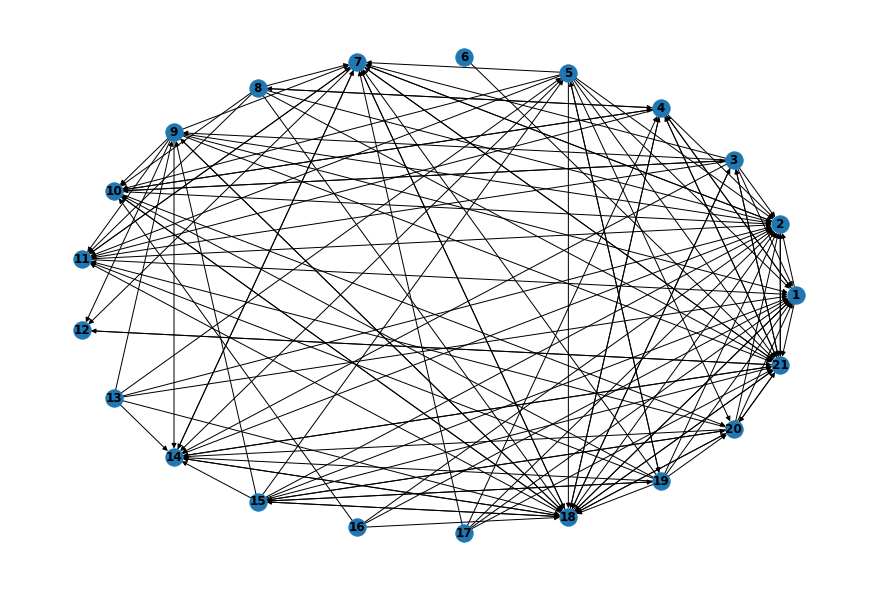

In [8]:
data_las = locally_aggregated_structures(data)

G_las = plot_network(data_las)

nx.draw_shell(G_las, with_labels=True, font_weight='bold')

In [9]:
df_las = pd.DataFrame([], index=range(1, 22))
df_las['LAS Out Degree'] = pd.Series(dict(G_las.out_degree()))
df_las['LAS In Degree'] = pd.Series(dict(G_las.in_degree()))

df_las

,LAS Out Degree,LAS In Degree
1,4,12
2,2,18
3,9,3
4,7,6
5,10,3
6,1,0
7,6,11
8,7,1
9,9,4
10,5,8


### Summary of Node Degrees 

In [10]:
network_degrees = df_cs.merge(df_las,
                              left_index=True, 
                              right_index=True)
network_degrees

,CS Out Degree,CS In Degree,LAS Out Degree,LAS In Degree
1,5,1,4,12
2,5,18,2,18
3,5,0,9,3
4,4,4,7,6
5,5,3,10,3
6,4,3,1,0
7,5,10,6,11
8,4,1,7,1
9,5,2,9,4
10,1,2,5,8


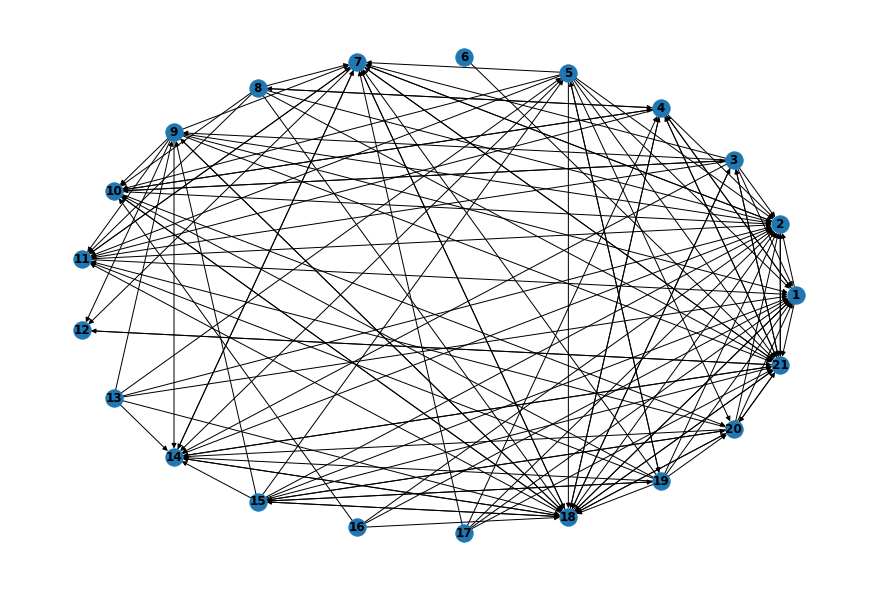

In [11]:
data_las = locally_aggregated_structures(data)

G_las = plot_network(data_las)

nx.draw_shell(G_las, with_labels=True, font_weight='bold', )

## Selecting 4 Representatives

### Advice getters vote for advisors 

In [12]:
def voterank(G, number_of_nodes=None):
    """Select a list of influential nodes in a graph using VoteRank algorithm

    VoteRank [1]_ computes a ranking of the nodes in a graph G based on a
    voting scheme. With VoteRank, all nodes vote for each of its in-neighbours
    and the node with the highest votes is elected iteratively. The voting
    ability of out-neighbors of elected nodes is decreased in subsequent turns.

    Note: We treat each edge independently in case of multigraphs.

    Parameters
    ----------
    G : graph
        A NetworkX graph.

    number_of_nodes : integer, optional
        Number of ranked nodes to extract (default all nodes).

    Returns
    -------
    voterank : list
        Ordered list of computed seeds.
        Only nodes with positive number of votes are returned.

    References
    ----------
    .. [1] Zhang, J.-X. et al. (2016).
        Identifying a set of influential spreaders in complex networks.
        Sci. Rep. 6, 27823; doi: 10.1038/srep27823.
    """
    influential_nodes = []
    voterank = {}
    if len(G) == 0:
        return influential_nodes
    if number_of_nodes is None or number_of_nodes > len(G):
        number_of_nodes = len(G)
    if G.is_directed():
        # For directed graphs compute average out-degree
        avgDegree = sum(deg for _, deg in G.out_degree()) / len(G)
    else:
        # For undirected graphs compute average degree
        avgDegree = sum(deg for _, deg in G.degree()) / len(G)
    # step 1 - initiate all nodes to (0,1) (score, voting ability)
    for n in G.nodes():
        voterank[n] = [0, 1]
    # Repeat steps 1b to 4 until num_seeds are elected.
    for _ in range(number_of_nodes):
        # step 1b - reset rank
        for n in G.nodes():
            voterank[n][0] = 0
        # step 2 - vote
        for n, nbr in G.edges():
            # In directed graphs nodes only vote for their in-neighbors
            voterank[n][0] += voterank[nbr][1]
            if not G.is_directed():
                voterank[nbr][0] += voterank[n][1]
        for n in influential_nodes:
            voterank[n][0] = 0
        # step 3 - select top node
        n = max(G.nodes, key=lambda x: voterank[x][0])
        if voterank[n][0] == 0:
            return influential_nodes
        influential_nodes.append(n)
        # weaken the selected node
        voterank[n] = [0, 0]
        # step 4 - update voterank properties
        for _, nbr in G.edges(n):
            voterank[nbr][1] -= 1 / avgDegree
            voterank[nbr][1] = max(voterank[nbr][1], 0)
    return influential_nodes

In [13]:
ambassadors = voterank(G_las, number_of_nodes=4)

not_represented = np.array(np.where(data_las[:, np.array(ambassadors) - 1].sum(axis=1) == 0)) + 1

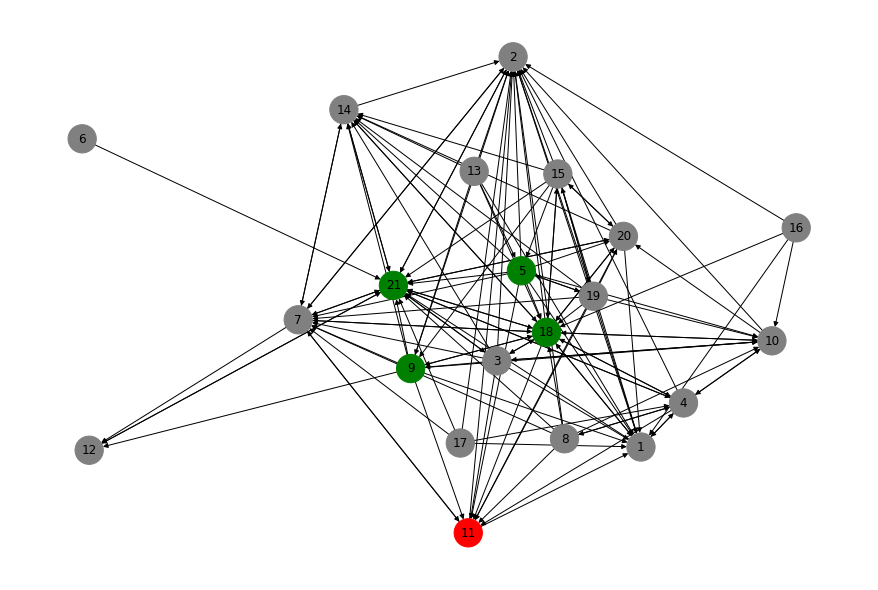

In [14]:
color_map = []
for node in G_las:
    if node in ambassadors:
        color_map.append('green')
    elif node in not_represented:
        color_map.append('red')
    else: 
        color_map.append('gray')      
nx.draw(G_las, node_color=color_map, with_labels=True, node_size=800)
plt.show()

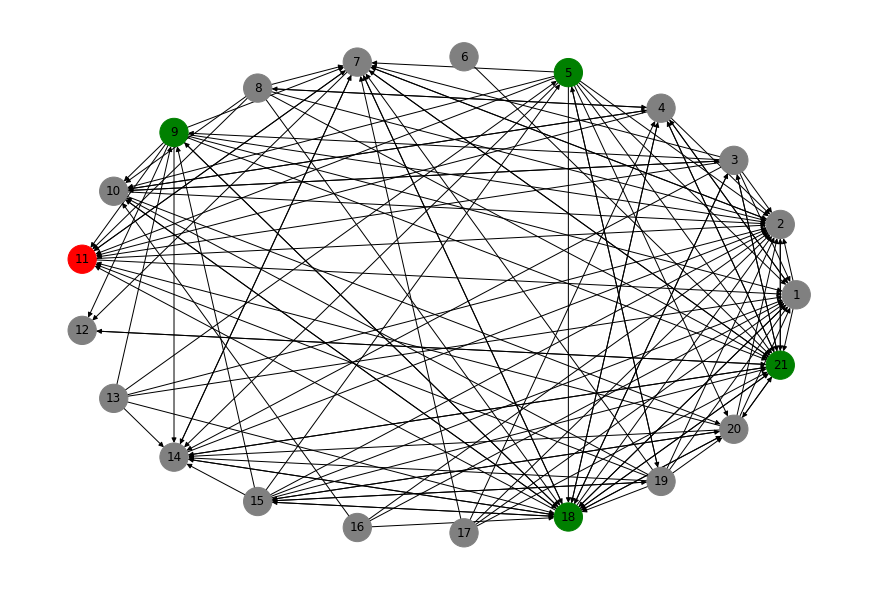

In [15]:
nx.draw_shell(G_las, node_color=color_map, with_labels=True, node_size=800)

#### Representation Map 

In [16]:
representation_map = np.argwhere(data_las[:, np.array(ambassadors) - 1] == 1)

In [17]:
ambassadors

[18, 5, 9, 21]

In [18]:
rep_dict = {k: [] for k in range(1,22)}

for i in representation_map:
    rep_dict[i[0] + 1].append(ambassadors[i[1]])
rep_dict = {k: [k] if k in ambassadors else rep_dict[k] for k in rep_dict}

In [19]:
rep_dict

{1: [18, 21],
 2: [21],
 3: [18, 9, 21],
 4: [18, 21],
 5: [5],
 6: [21],
 7: [18, 21],
 8: [18, 21],
 9: [9],
 10: [18],
 11: [],
 12: [21],
 13: [18, 5, 9],
 14: [18, 21],
 15: [18, 5, 9, 21],
 16: [18],
 17: [21],
 18: [18],
 19: [18, 5],
 20: [18, 21],
 21: [21]}

For the nodes that can be represented by more than 1 ambassador, pick 1 ambassador at random, just for visualization purposes.

In [20]:
np.random.seed(94)
graph_rep_map = {k: np.random.choice(rep_dict[k]) if rep_dict[k] != [] else -1 for k in rep_dict}

Styling of the nodes, ambassador nodes are made bigger and representation groups are colored by the same colors.

In [21]:
color_dict = {ambassadors[0]: 'green',
              ambassadors[1]: 'red',
              ambassadors[2]: 'grey',
              ambassadors[3]: 'yellow'}

color_map_rep = []

for i in graph_rep_map:
    if graph_rep_map[i] > 0:
        color_map_rep.append(color_dict[graph_rep_map[i]])
    else:
        color_map_rep.append('white')

node_size_array = 800*np.ones(21)
node_size_array[np.array(ambassadors)-1] *= 4

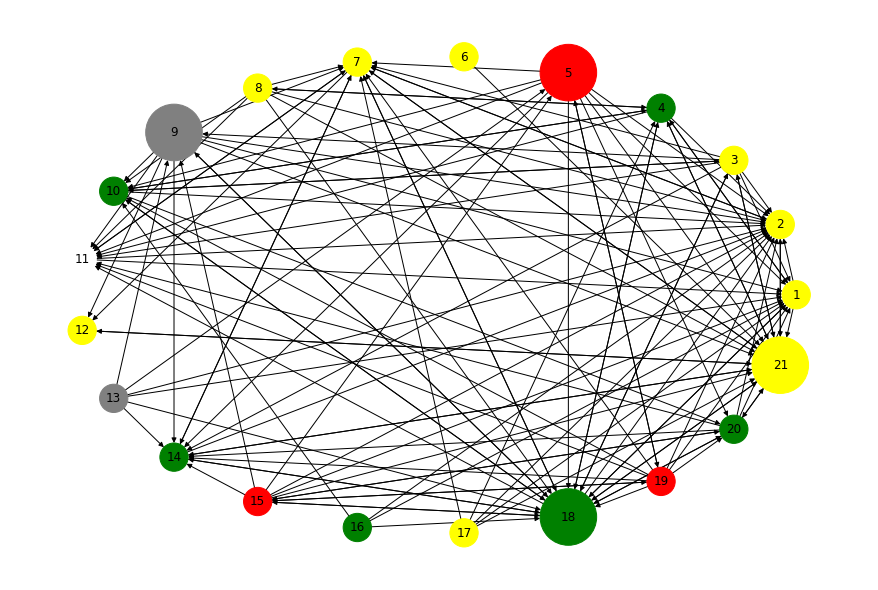

In [22]:
nx.draw_shell(G_las, 
              node_color=color_map_rep, 
              with_labels=True, 
              node_size=node_size_array)

### Advisors vote for advise getters 

In [23]:
G_las_reverse = G_las.reverse(copy=True)

ambassadors_reverse = voterank(G_las_reverse, number_of_nodes=4)

not_represented_reverse = np.array(np.where(data_las[:, np.array(ambassadors_reverse) - 1].sum(axis=1) == 0)) + 1

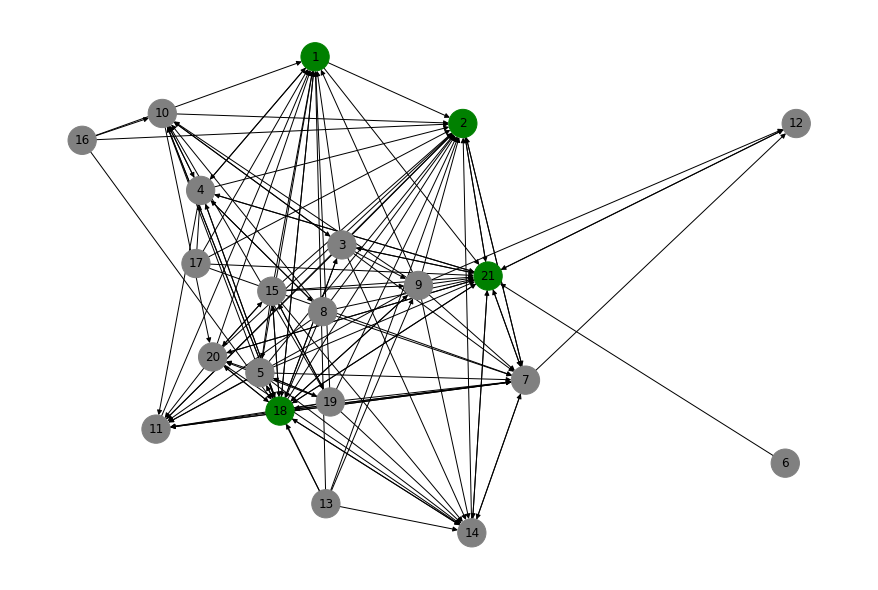

In [24]:
color_map = []
for node in G_las:
    if node in ambassadors_reverse:
        color_map.append('green')
    elif node in not_represented_reverse:
        color_map.append('red')
    else: 
        color_map.append('gray')      
nx.draw(G_las, node_color=color_map, with_labels=True, node_size=800)
plt.show()

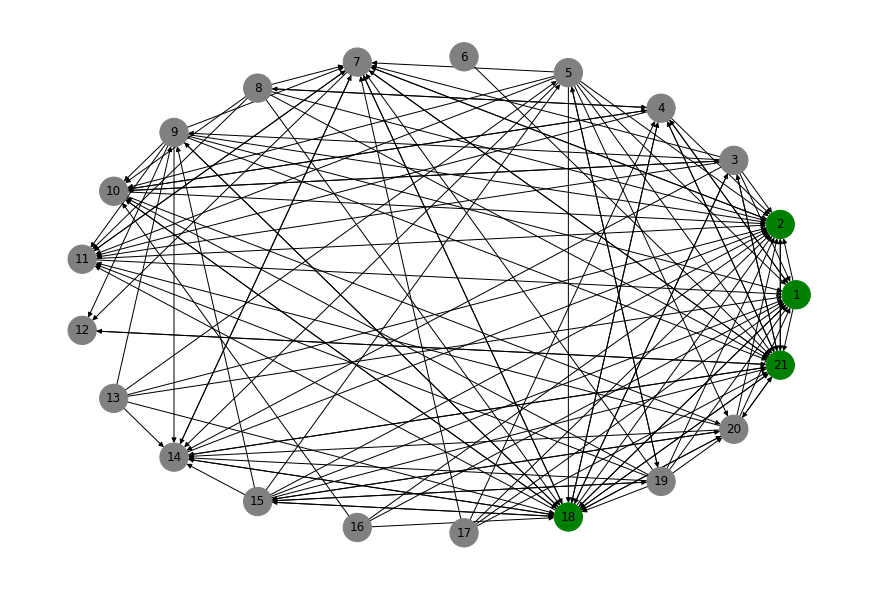

In [25]:
nx.draw_shell(G_las, node_color=color_map, with_labels=True, node_size=800)

#### Representation Map 

In [26]:
representation_map_rev = np.argwhere(data_las[:, np.array(ambassadors_reverse) - 1] == 1)

In [27]:
ambassadors_reverse

[2, 18, 21, 1]

In [28]:
rep_dict_rev = {k: [] for k in range(1,22)}

for i in representation_map_rev:
    rep_dict_rev[i[0] + 1].append(ambassadors_reverse[i[1]])
rep_dict_rev = {k: [k] if k in ambassadors_reverse else rep_dict_rev[k] for k in rep_dict_rev}

In [29]:
rep_dict_rev

{1: [1],
 2: [2],
 3: [2, 18, 21, 1],
 4: [2, 18, 21, 1],
 5: [2, 18, 21, 1],
 6: [21],
 7: [2, 18, 21],
 8: [2, 18, 21],
 9: [2, 18, 21, 1],
 10: [2, 18],
 11: [2, 1],
 12: [21],
 13: [2, 18, 1],
 14: [2, 18, 21],
 15: [2, 18, 21, 1],
 16: [2, 18, 1],
 17: [2, 21, 1],
 18: [18],
 19: [2, 18, 1],
 20: [2, 18, 21, 1],
 21: [21]}

For the nodes that can be represented by more than 1 ambassador, pick 1 ambassador at random, just for visualization purposes.

In [30]:
np.random.seed(94)
graph_rep_map_rev = {k: np.random.choice(rep_dict_rev[k]) if rep_dict_rev[k] != [] else -1 for k in rep_dict_rev}

Styling of the nodes, ambassador nodes are made bigger and representation groups are colored by the same colors.

In [31]:
color_dict_rev = {ambassadors_reverse[0]: 'green',
              ambassadors_reverse[1]: 'red',
              ambassadors_reverse[2]: 'grey',
              ambassadors_reverse[3]: 'yellow'}

color_map_rep_rev = []

for i in graph_rep_map_rev:
    if graph_rep_map_rev[i] > 0:
        color_map_rep_rev.append(color_dict_rev[graph_rep_map_rev[i]])
    else:
        color_map_rep_rev.append('white')

node_size_array_rev = 800*np.ones(21)
node_size_array_rev[np.array(ambassadors_reverse)-1] *= 4

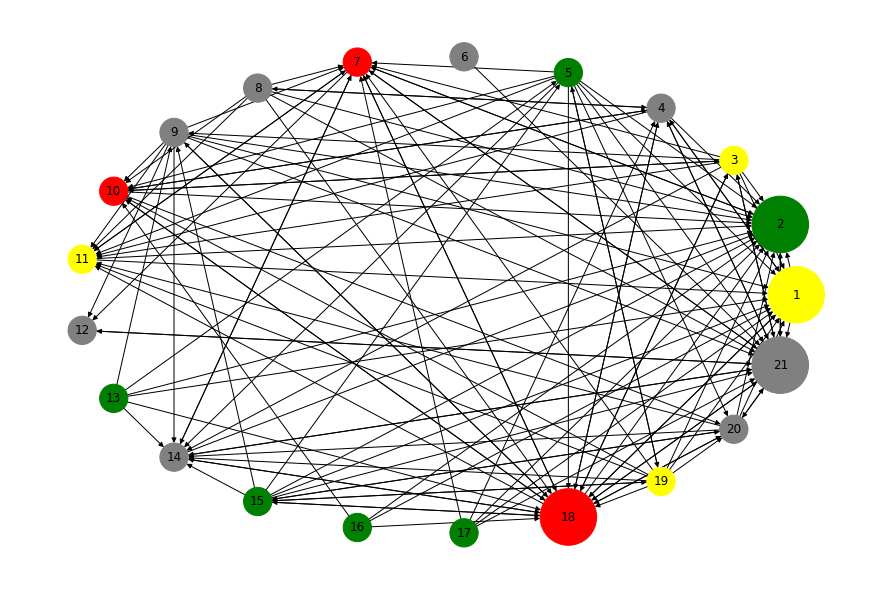

In [32]:
nx.draw_shell(G_las, 
              node_color=color_map_rep_rev, 
              with_labels=True, 
              node_size=node_size_array_rev)